In [71]:
%cd "F:\University\Master's Thesis\Datasets\rnd"

F:\University\Master's Thesis\Datasets\rnd


In [17]:
%pip install pytorch-lightning
%pip install lightning


Note: you may need to restart the kernel to use updated packages.


In [72]:
import os
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [76]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss

# List of columns you want to read
selected_columns = ["VM", "Timestamp [ms]", "Memory usage [%]", "time_idx"]

file_path = 'bitbrains_structured_data.csv'
df = pd.read_csv(file_path, usecols=selected_columns)
df.head(5)

,VM,Timestamp [ms],time_idx,Memory usage [%]
0,VM001,1372629804,1,12.588394
1,VM001,1372630104,2,5.579711
2,VM001,1372630404,3,2.245485
3,VM001,1372630704,4,0.952620
4,VM001,1372631004,5,2.041364


In [102]:
from pytorch_forecasting.data import NaNLabelEncoder

max_prediction_length = 64
max_encoder_length = 256
training_cutoff = df["time_idx"].max() - max_prediction_length


context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Memory usage [%]",
    group_ids=["VM"],
    categorical_encoders={"VM": NaNLabelEncoder().fit(df.VM)},
    # only unknown variable is "value" - and N-HiTS can also not take any additional variables
    time_varying_unknown_reals=['Memory usage [%]'],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    allow_missing_timesteps= True,
)

validation = TimeSeriesDataSet.from_dataset(training, df, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [103]:
training.get_parameters()

{'time_idx': 'time_idx',
 'target': 'Memory usage [%]',
 'group_ids': ['VM'],
 'weight': None,
 'max_encoder_length': 256,
 'min_encoder_length': 256,
 'min_prediction_idx': 1,
 'min_prediction_length': 64,
 'max_prediction_length': 64,
 'static_categoricals': [],
 'static_reals': [],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': [],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['Memory usage [%]'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': True,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': EncoderNormalizer(
 	method='standard',
 	center=True,
 	max_length=None,
 	transformation=None,
 	method_kwargs={}
 ),
 'categorical_encoders': {'VM': NaNLabelEncoder(add_nan=False, warn=True),
  '__group_id__VM': NaNLabelEncoder(add_nan=False, warn=True)},
 'scalers': {},
 'randomize_length': None,
 'predict_mode': False}

In [104]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.6655)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0012022644346174132
Restoring states from the checkpoint path at F:\University\Master's Thesis\Datasets\rnd\.lr_find_9b6b7156-7a77-4310-a383-d62e4b4936fc.ckpt
Restored all states from the checkpoint at F:\University\Master's Thesis\Datasets\rnd\.lr_find_9b6b7156-7a77-4310-a383-d62e4b4936fc.ckpt


suggested learning rate: 0.0012022644346174132


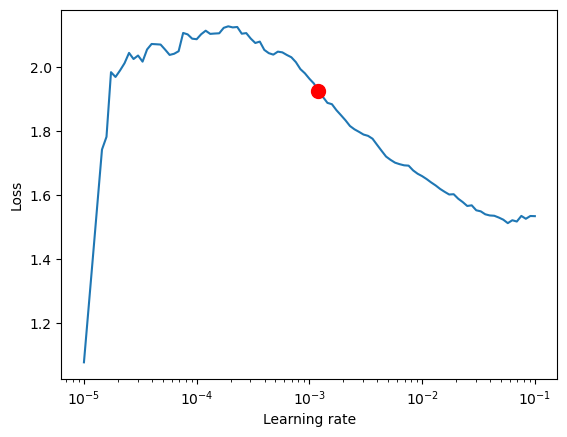

In [105]:
from pytorch_forecasting.metrics import MQF2DistributionLoss

pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=0.1)
net = NHiTS.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=QuantileLoss(),
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
)

# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e-1
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [106]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
)


net = NHiTS.from_dataset(
    training,
    learning_rate=1.2e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
    loss=QuantileLoss(),
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [107]:
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name            | Type           | Params
---------------------------------------------------
0 | loss            | QuantileLoss   | 0     
1 | logging_metrics | ModuleList     | 0     
2 | embeddings      | MultiEmbedding | 0     
3 | model           | NHiTS          | 112 K 
---------------------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.448     Total estimated model params size (MB)


Sanity Checking: |                                               | 0/? [00:00<?, ?it/s]

Training: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

In [108]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

In [109]:
# Saving the model to disk
import pickle

# save study results - also we can resume tuning at a later point in time
with open("nhits_bitbrains_v1.pkl", "wb") as fout:
    pickle.dump(best_model, fout)

In [110]:
import pickle

with open("nhits_bitbrains_v1.pkl",'rb') as f:
    best_nhits=pickle.load(f)
    

In [111]:
predictions = best_nhits.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(predictions.output, predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.6726)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


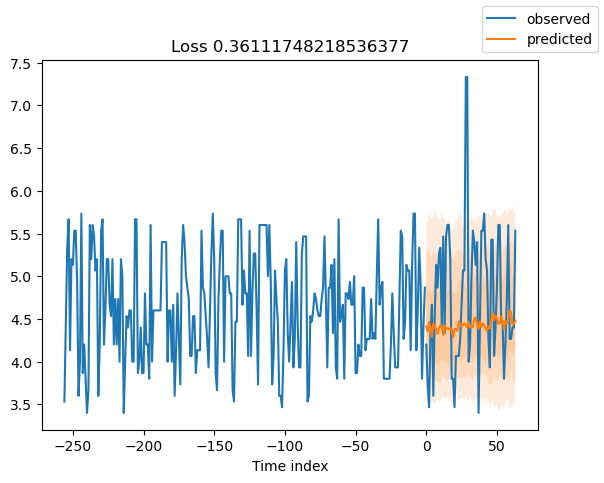

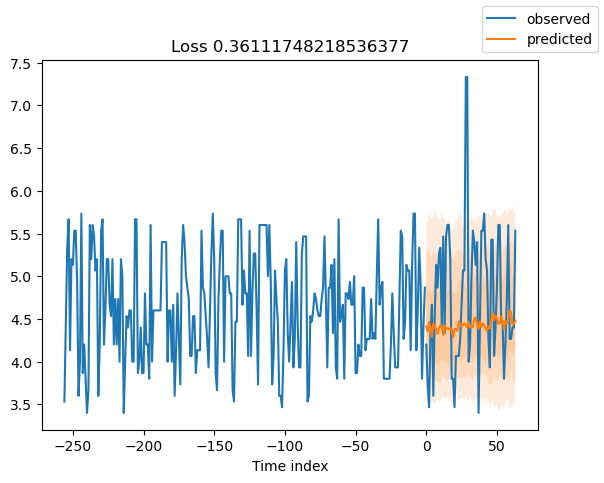

In [114]:
raw_predictions = best_nhits.predict(val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))

best_nhits.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)

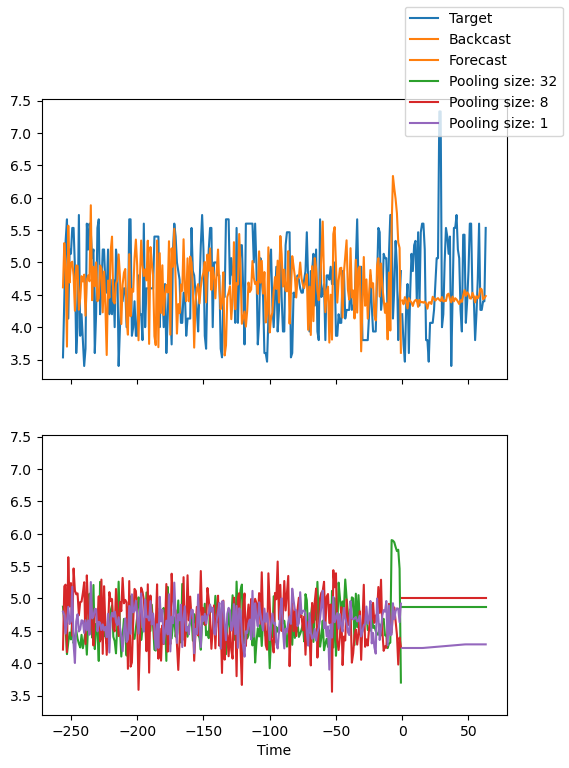

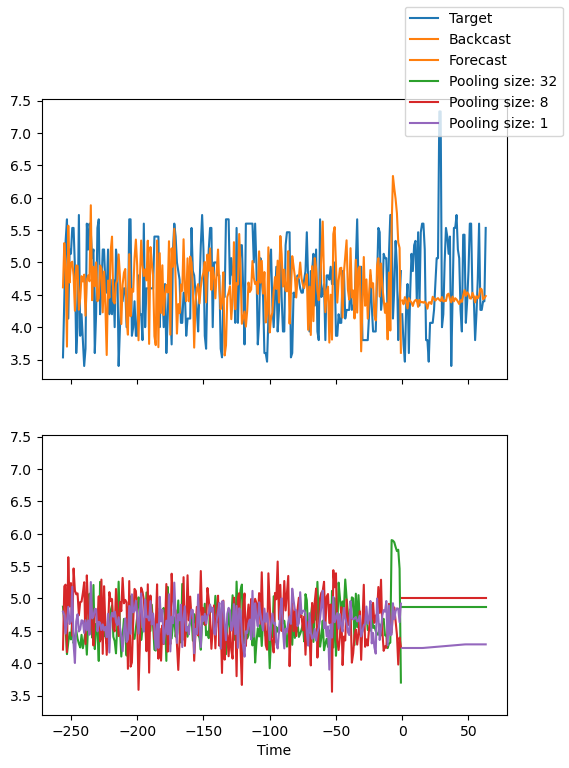

In [120]:
for idx in range(2):  # plot 10 examples
    best_nhits.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=0)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


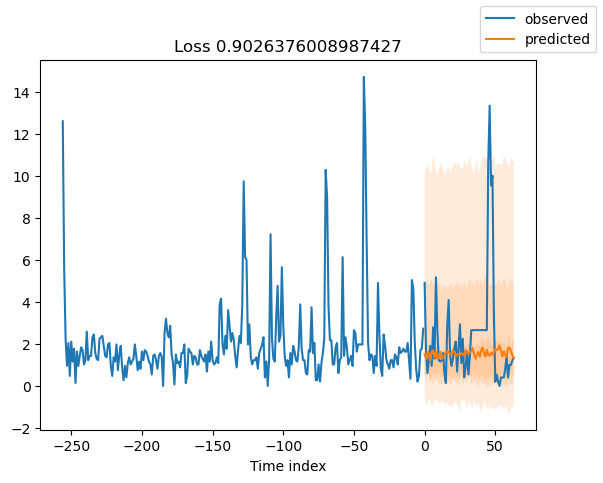

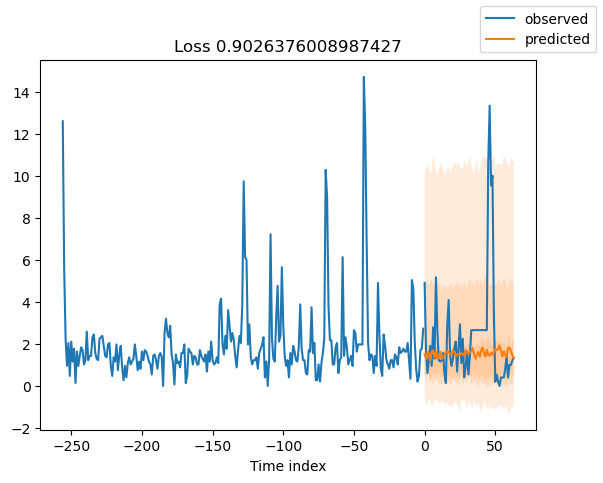

In [118]:
raw_prediction = best_nhits.predict(
    training.filter(lambda x: (x["VM"] == "VM001")),
    mode="raw",
    return_x=True,
)
best_nhits.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0, add_loss_to_title=True)